In [12]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

np.random.seed(42)

In [14]:
DATA_DIR = Path(".")

In [15]:
DATA_2D_PATH = DATA_DIR / "data_2d.csv"
MNIST_PATH   = DATA_DIR / "mnist.csv"

print("DATA_2D_PATH:", DATA_2D_PATH)
print("MNIST_PATH:", MNIST_PATH)
print("Exists 2D:", DATA_2D_PATH.exists())
print("Exists MNIST:", MNIST_PATH.exists())

DATA_2D_PATH: data_2d.csv
MNIST_PATH: mnist.csv
Exists 2D: True
Exists MNIST: True


In [16]:
def load_csv_no_header(path: Path) -> pd.DataFrame:
    """
    Loads CSV assuming there is NO header row.
    Returns DataFrame with integer column indices.
    """
    if not Path(path).exists():
        raise FileNotFoundError(f"File not found: {path}")
    df = pd.read_csv(path, header=None)
    return df

def show_df_info(df: pd.DataFrame, name: str, head: int = 5):
    print(f"\n{name} shape:", df.shape)
    display(df.head(head))

In [17]:
df_2d = load_csv_no_header(DATA_2D_PATH)
show_df_info(df_2d, "df_2d")


df_2d shape: (200, 3)


,0,1,2
0,0.0,-0.768716,0.460860
1,0.0,2.687848,2.366961
2,0.0,-0.201379,0.470430
3,0.0,0.608496,1.225400
4,0.0,-0.082282,1.137218


In [18]:
X_2d = df_2d.iloc[:, :2].astype(float).values

print("X_2d shape:", X_2d.shape)

X_2d shape: (200, 2)


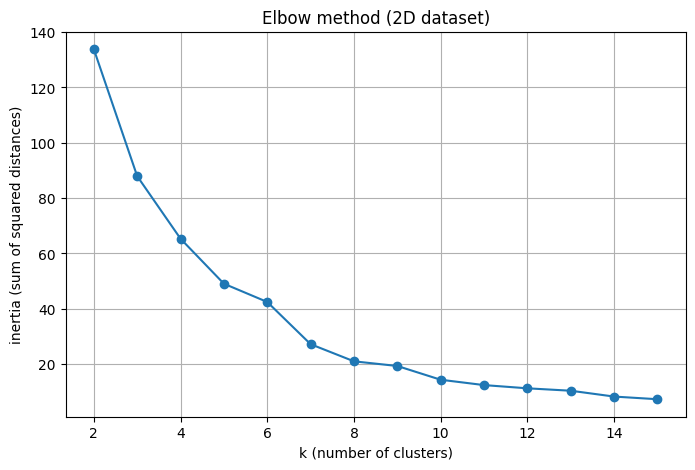

In [19]:
def elbow_kmeans(X, k_min=2, k_max=15, random_state=42):
    ks = list(range(k_min, k_max + 1))
    inertias = []
    for k in ks:
        km = KMeans(n_clusters=k, random_state=random_state, n_init="auto")
        km.fit(X)
        inertias.append(km.inertia_)
    return ks, inertias

def plot_elbow(ks, inertias, title):
    plt.figure(figsize=(8, 5))
    plt.plot(ks, inertias, marker="o")
    plt.title(title)
    plt.xlabel("k (number of clusters)")
    plt.ylabel("inertia (sum of squared distances)")
    plt.grid(True)
    plt.show()

ks_2d, inertias_2d = elbow_kmeans(X_2d, k_min=2, k_max=15, random_state=42)
plot_elbow(ks_2d, inertias_2d, "Elbow method (2D dataset)")

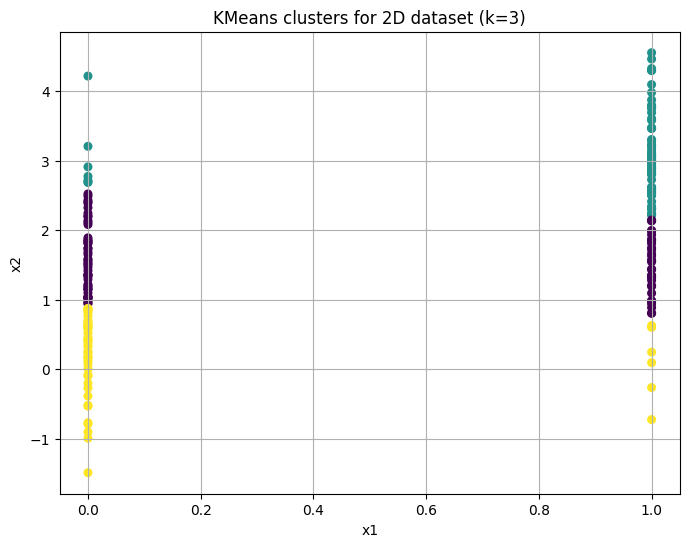

In [21]:
K_2D = 3

kmeans_2d = KMeans(n_clusters=K_2D, random_state=42, n_init="auto")
labels_2d = kmeans_2d.fit_predict(X_2d)

plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_2d, s=30)
plt.title(f"KMeans clusters for 2D dataset (k={K_2D})")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.show()

In [23]:
if df_2d.shape[1] >= 3:
    y_true_2d = df_2d.iloc[:, 2].values

    uniq = pd.unique(y_true_2d)
    if len(uniq) <= 20:
        ari = adjusted_rand_score(y_true_2d, labels_2d)
        nmi = normalized_mutual_info_score(y_true_2d, labels_2d)
        print("Looks like there are true labels in column 3.")
        print("ARI:", ari)
        print("NMI:", nmi)
    else:
        print("3rd column doesn't look like labels (too many unique values). Skipping ARI/NMI.")

3rd column doesn't look like labels (too many unique values). Skipping ARI/NMI.


In [24]:
df_mnist = load_csv_no_header(MNIST_PATH)
show_df_info(df_mnist, "df_mnist")


col0 = df_mnist.iloc[:, 0].values
is_digit_like = np.all(np.isin(np.unique(col0), np.arange(10)))

if is_digit_like:
    y_true = df_mnist.iloc[:, 0].astype(int).values
    X_mnist = df_mnist.iloc[:, 1:].astype(float).values
    print("Detected: first column is digit label (0..9).")
else:
    y_true = None
    X_mnist = df_mnist.astype(float).values
    print("No digit labels detected; using all columns as features.")

print("X_mnist shape:", X_mnist.shape)
print("y_true:", None if y_true is None else (y_true.shape, np.unique(y_true)))


df_mnist shape: (500, 785)


,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Detected: first column is digit label (0..9).
X_mnist shape: (500, 784)
y_true: ((500,), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))


In [25]:
scaler = StandardScaler()
X_mnist_sc = scaler.fit_transform(X_mnist)

print("Scaled X_mnist_sc shape:", X_mnist_sc.shape)

Scaled X_mnist_sc shape: (500, 784)


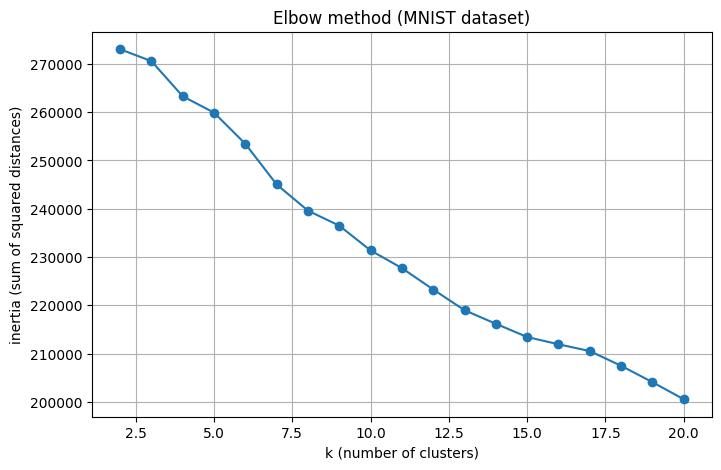

In [26]:
ks_m, inertias_m = elbow_kmeans(X_mnist_sc, k_min=2, k_max=20, random_state=42)
plot_elbow(ks_m, inertias_m, "Elbow method (MNIST dataset)")

In [27]:
K_MNIST = 10  # <- найчастіше 10, бо цифр 10

kmeans_m = KMeans(n_clusters=K_MNIST, random_state=42, n_init="auto")
labels_m = kmeans_m.fit_predict(X_mnist_sc)

print("Chosen k for MNIST:", K_MNIST)

Chosen k for MNIST: 10


In [28]:
if y_true is not None:
    ari = adjusted_rand_score(y_true, labels_m)
    nmi = normalized_mutual_info_score(y_true, labels_m)
    print("ARI:", ari)
    print("NMI:", nmi)

ARI: 0.23546976929416727
NMI: 0.37273281806432895


Explained variance ratio (2 components): [0.07302906 0.05058049] | sum: 0.12360955596744566


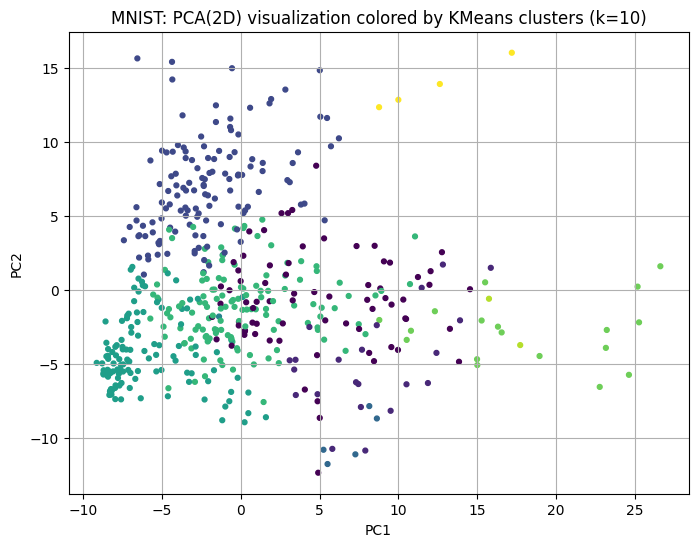

In [29]:
pca = PCA(n_components=2, random_state=42)
X_mnist_pca2 = pca.fit_transform(X_mnist_sc)

print("Explained variance ratio (2 components):", pca.explained_variance_ratio_,
      "| sum:", pca.explained_variance_ratio_.sum())

plt.figure(figsize=(8, 6))
plt.scatter(X_mnist_pca2[:, 0], X_mnist_pca2[:, 1], c=labels_m, s=12)
plt.title(f"MNIST: PCA(2D) visualization colored by KMeans clusters (k={K_MNIST})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

In [30]:
if y_true is not None:
    ct = pd.crosstab(
        pd.Series(labels_m, name="cluster"),
        pd.Series(y_true, name="digit")
    )
    display(ct)

    # majority digit per cluster
    majority = ct.idxmax(axis=1)
    print("\nMajority digit per cluster:")
    display(majority)
else:
    print("No y_true digits available -> skipping crosstab.")

digit,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,11,0,4,25,0,20,2,0,8,3
1,1,0,17,1,0,0,1,0,2,0
2,0,0,3,2,35,1,1,32,11,42
3,1,0,4,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0
5,0,67,16,12,4,2,0,10,3,3
6,14,0,10,5,11,26,36,7,16,6
7,14,0,0,0,1,1,2,0,0,0
8,1,0,0,0,0,0,1,0,0,0



Majority digit per cluster:


,0
cluster,
0,3
1,2
2,9
3,2
4,2
5,1
6,6
7,0
8,0


In [32]:
def plot_centroids_as_images(kmeans_model, scaler=None, n_cols=5, title="Centroids"):
    centroids = kmeans_model.cluster_centers_



    if scaler is not None:
        centroids = scaler.inverse_transform(centroids)

    n_clusters = centroids.shape[0]
    n_rows = int(np.ceil(n_clusters / n_cols))

    plt.figure(figsize=(2.2 * n_cols, 2.2 * n_rows))
    for i in range(n_clusters):
        plt.subplot(n_rows, n_cols, i + 1)
        img = centroids[i].reshape(28, 28)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(f"c{i}")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

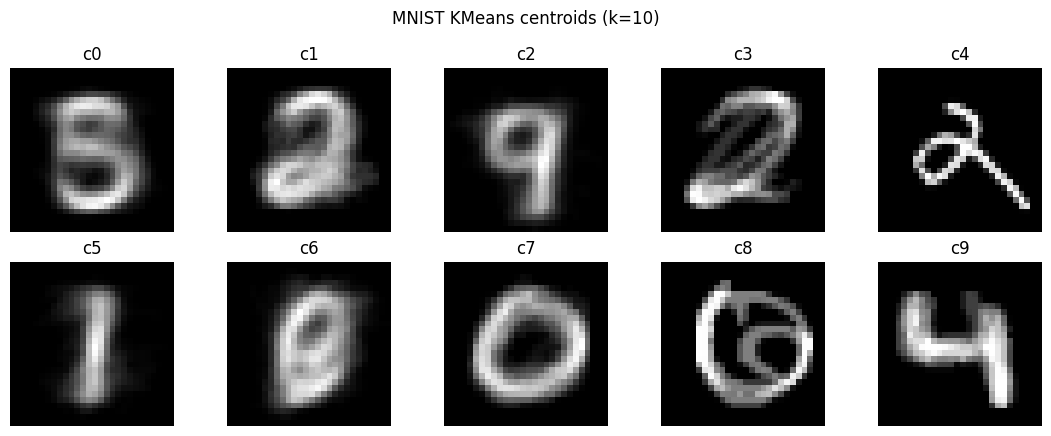

In [33]:
if X_mnist.shape[1] == 784:
    plot_centroids_as_images(kmeans_m, scaler=scaler, n_cols=5,
                             title=f"MNIST KMeans centroids (k={K_MNIST})")
else:
    print("X_mnist does not have 784 features -> cannot reshape to 28x28.")

In [34]:
print("=== FINAL SUMMARY ===")
print(f"2D dataset: k={K_2D}, X_2d shape={X_2d.shape}")
print(f"MNIST dataset: k={K_MNIST}, X_mnist shape={X_mnist.shape}")

if y_true is not None:
    ari = adjusted_rand_score(y_true, labels_m)
    nmi = normalized_mutual_info_score(y_true, labels_m)
    print("MNIST ARI:", ari)
    print("MNIST NMI:", nmi)

=== FINAL SUMMARY ===
2D dataset: k=3, X_2d shape=(200, 2)
MNIST dataset: k=10, X_mnist shape=(500, 784)
MNIST ARI: 0.23546976929416727
MNIST NMI: 0.37273281806432895
